# Computing the GP-DRT

In this example we are going to use a simple model to illustrate how the GP-DRT model works for impedance data that is unbounded. We are going to take the data from the following article:
Wu et al. Dual-phase MoS2 as a high-performance sodium-ion battery anode. Journal of Materials Chemistry A, 8, 2114-2122 (2020). https://doi.org/10.1039/C9TA11913B

In [1]:
# import the libraries needed
import importlib
import GP_hilbert_unbounded
importlib.reload(GP_hilbert_unbounded)

import numpy as np
import matplotlib.pyplot as plt
from math import pi, log10, sqrt
from scipy.optimize import minimize
import seaborn as sns
import pandas as pd

In [2]:
# plot standards
plt.rc('font', family='serif', size=15)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

## 1) Upload impedance data, $Z_{\rm exp}(\omega)$, and show both impedance  and admittance, $Y_{\rm exp}(\omega)$

### 1.1) Upload the data from csv file

In [3]:
Z_data = pd.read_csv('./data/MoS2 2H.csv')
freq_vec, Z_exp = Z_data['freq'].values, Z_data['Z_Re'].values + 1j*Z_data['Z_Im'].values
freq_min = min(freq_vec)
freq_max = max(freq_vec)
tau_vec = 1./freq_vec
omega_vec = 2.*pi*freq_vec
N_freqs = len(freq_vec)

### 1.2) Plot the impedance $Z_{\rm exp}(\omega)$

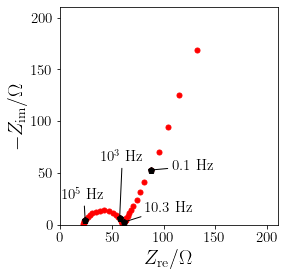

In [4]:
# plot starting impedance
fig, ax = plt.subplots()

plt.plot(np.real(Z_exp), -np.imag(Z_exp), 'o',
         markersize=5, color='red', label='exp')

plt.plot(np.real(Z_exp[6:30:12]), -np.imag(Z_exp[6:30:12]),
         'p', markersize=7, color="black")
plt.plot(np.real(Z_exp[42]), -np.imag(Z_exp[42]),
         'p', markersize=7, color="black")
plt.plot(np.real(Z_exp[30]), -np.imag(Z_exp[30]),
         'p', markersize=7, color="black")

plt.annotate(r'$0.1$ Hz', xy=(np.real(Z_exp[6]), -np.imag(Z_exp[6])),
             xytext=(np.real(Z_exp[6])+20, -np.imag(Z_exp[6])),
             arrowprops=dict(arrowstyle='-', connectionstyle='arc'))
plt.annotate(r'$10.3$ Hz', xy=(np.real(Z_exp[18]), -np.imag(Z_exp[18])),
             xytext=(np.real(Z_exp[18])+20, 10-np.imag(Z_exp[18])),
             arrowprops=dict(arrowstyle='-', connectionstyle='arc'))
plt.annotate(r'$10^3$ Hz', xy=(np.real(Z_exp[30]), -np.imag(Z_exp[30])),
             xytext=(np.real(Z_exp[30])-18, 55-np.imag(Z_exp[30])),
             arrowprops=dict(arrowstyle='-', connectionstyle='arc'))
plt.annotate(r'$10^{5}$ Hz', xy=(np.real(Z_exp[42]), -np.imag(Z_exp[42])),
             xytext=(np.real(Z_exp[42])-22, 20-np.imag(Z_exp[42])),
             arrowprops=dict(arrowstyle='-', connectionstyle='arc'))

plt.axis('scaled')
plt.xlim(0, 210)
plt.ylim(0, 210)
plt.xticks(range(0, 210, 50))
plt.yticks(range(0, 210, 50))

plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize=20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize=20)
plt.show()

### 1.3) Plot the admittance $Y_{\rm exp}(\omega)$

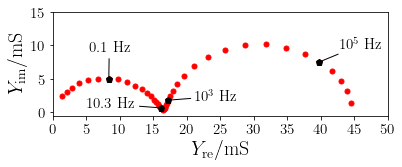

In [5]:
# Y_exact = 1000/Z_exact
Y_exp = 1000/Z_exp # units are mS

fig, ax = plt.subplots()

plt.plot(np.real(Y_exp), np.imag(Y_exp), 'o', markersize=5, color='red', label='exp')
plt.plot(np.real(Y_exp[6:43:12]), np.imag(Y_exp[6:43:12]), 'p', markersize=7, color="black")

plt.annotate(r'$0.1$ Hz', xy=(np.real(Y_exp[6]), np.imag(Y_exp[6])),
             xytext=(np.real(Y_exp[6])-3, 2+np.imag(Y_exp[6])+2),
             arrowprops=dict(arrowstyle='-', connectionstyle='arc'))
plt.annotate(r'$10.3$ Hz', xy=(np.real(Y_exp[18]), np.imag(Y_exp[18])),
             xytext=(np.real(Y_exp[18])-11, np.imag(Y_exp[18])),
             arrowprops=dict(arrowstyle='-', connectionstyle='arc'))
plt.annotate(r'$10^{3}$ Hz', xy=(np.real(Y_exp[30]), np.imag(Y_exp[30])),
             xytext=(np.real(Y_exp[30])+4, np.imag(Y_exp[30])),
             arrowprops=dict(arrowstyle='-', connectionstyle='arc'))
plt.annotate(r'$10^{5}$ Hz', xy=(np.real(Y_exp[42]), np.imag(Y_exp[42])),
             xytext=(np.real(Y_exp[42])+3, np.imag(Y_exp[42])+2),
             arrowprops=dict(arrowstyle='-', connectionstyle='arc'))

plt.axis('scaled')
plt.xlim(0, 50)
plt.ylim(-0.5, 15)

plt.xticks(range(0, 51, 5))
plt.yticks(range(0, 16, 5))

plt.xlabel(r'$Y_{\rm re}/{\rm mS}$', fontsize=20)
plt.ylabel(r'$Y_{\rm im}/{\rm mS}$', fontsize=20)
plt.show()

### 2.1) Set the kernel options 

In [6]:
ker_opts = {
    'sigma_DCT': 1.,
    'sigma_SB': 0.5,
    'ell': 15.,
    'tau_min': 2E-6,
    'DCT': True,
    'SB': True,
    'SB_ker_type': 'IQ',
}

# these values are nominal

### 2.2) Initialize the hyperparameters

In [7]:
sigma_n = 6.25E-3
sigma_DCT = 2.85
sigma_SB = 0.25
ell = 4.25


### 2.3) Maximize the NMLL

In [8]:
theta_0 = np.array([sigma_n, sigma_DCT, sigma_SB, ell])
seq_theta = np.copy(theta_0)
def print_results(theta):
    global seq_theta
    seq_theta = np.vstack((seq_theta, theta))
    print('%.4E, %.4E, %.4E, %.4E; evidence = %.8E'%(theta[0], theta[1], theta[2], theta[3], GP_hilbert_unbounded.NMLL_fct(theta, Y_exp.imag, omega_vec, ker_opts)))
    
res = minimize(GP_hilbert_unbounded.NMLL_fct, theta_0, args=(Y_exp.imag, omega_vec, ker_opts, 'im'), method='Powell', callback=print_results, options={'disp': True})
res = minimize(GP_hilbert_unbounded.NMLL_fct, res.x, args=(Y_exp.imag, omega_vec, ker_opts, 'im'), method='Nelder-Mead', callback=print_results, options={'disp': True})

theta = res.x
sigma_n, sigma_DRT, sigma_SB, ell = theta

6.2644E-03, 2.8500E+00, 2.2521E-01, 4.2311E+00; evidence = 1.97062215E+01
6.2384E-03, 2.8494E+00, 2.2498E-01, 4.2300E+00; evidence = 1.97061564E+01
Optimization terminated successfully.
         Current function value: 19.706156
         Iterations: 2
         Function evaluations: 139
6.2384E-03, 2.8494E+00, 2.2498E-01, 4.2300E+00; evidence = 1.97061564E+01
6.2384E-03, 2.8494E+00, 2.2498E-01, 4.2300E+00; evidence = 1.97061564E+01
6.2384E-03, 2.8494E+00, 2.2498E-01, 4.2300E+00; evidence = 1.97061564E+01
6.2384E-03, 2.8494E+00, 2.2498E-01, 4.2300E+00; evidence = 1.97061564E+01
6.2384E-03, 2.8494E+00, 2.2498E-01, 4.2300E+00; evidence = 1.97061564E+01
6.2384E-03, 2.8494E+00, 2.2498E-01, 4.2300E+00; evidence = 1.97061564E+01
6.2384E-03, 2.8494E+00, 2.2498E-01, 4.2300E+00; evidence = 1.97061564E+01
6.2384E-03, 2.8494E+00, 2.2498E-01, 4.2300E+00; evidence = 1.97061564E+01
6.2384E-03, 2.8494E+00, 2.2498E-01, 4.2300E+00; evidence = 1.97061564E+01
6.2384E-03, 2.8494E+00, 2.2498E-01, 4.2300E+00;

In [9]:
# update the values of the kernel
# as the GP_hilbert functions simply copy ker_opts
ker_opts['sigma_SB'] = sigma_SB
ker_opts['ell'] = ell
ker_opts['sigma_DCT'] = sigma_DCT

### 2.4) Check if the results are reasonable - $\Im(Y_{\rm exp})$ vs. the GP regression

#### 2.4.1) Run the GP regression

In [10]:
K_im = GP_hilbert_unbounded.mat_K(omega_vec, omega_vec, ker_opts, 'im')
Sigma = (sigma_n**2)*np.eye(N_freqs)
K_full = K_im + Sigma 

# cholesky factorization
L = np.linalg.cholesky(K_full)

# covariance matrix
inv_L = np.linalg.inv(L)
inv_K_full = np.dot(inv_L.T, inv_L)

N_star_freqs = N_freqs
freq_star_vec = np.copy(freq_vec)
omega_star_vec = 2.*pi*freq_star_vec

mu_star_vec = np.zeros_like(omega_star_vec)
sigma_star_vec = np.zeros_like(omega_star_vec)

for index, omega_star in enumerate(omega_star_vec):
    omega_star_np = np.array([omega_star])
    k_star = GP_hilbert_unbounded.mat_K(omega_vec, omega_star_np, ker_opts, 'im').flatten()
    k_star_star = GP_hilbert_unbounded.mat_K(omega_star_np, omega_star_np, ker_opts, 'im').flatten()
    mu_star_vec[index] = k_star@(inv_K_full@Y_exp.imag)
    sigma_star_vec[index] = np.sqrt(abs(k_star_star - k_star@(inv_K_full@k_star)))

#### 2.4.2) Plot the outcome of the GP regression

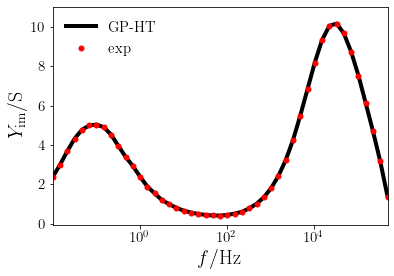

In [11]:
plt.fill_between(freq_star_vec, mu_star_vec-3*sigma_star_vec, mu_star_vec+3*sigma_star_vec,  facecolor='lightgrey')
plt.fill_between(freq_star_vec, mu_star_vec-2*sigma_star_vec, mu_star_vec+2*sigma_star_vec,  facecolor='silver')
plt.fill_between(freq_star_vec, mu_star_vec-sigma_star_vec, mu_star_vec+sigma_star_vec,  facecolor='grey')
plt.semilogx(freq_star_vec, mu_star_vec, linewidth=4, color='black', label='GP-HT')
plt.semilogx(freq_vec,  Y_exp.imag, 'o', markersize=5, color='red', label='exp')
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.xlim(freq_min, freq_max)
plt.ylim(-.05, 11)
plt.xscale('log')
plt.xlabel(r'$f/{\rm Hz}$', fontsize=20)
plt.ylabel(r'$Y_{\rm im}/\rm S$', fontsize=20)
plt.legend(frameon=False, fontsize = 15)

## 3) Compute and plot the GP-HT 

### 3.1) Compute

In [12]:
K_im = GP_hilbert_unbounded.mat_K(omega_vec, omega_vec, ker_opts, 'im')
Sigma = (sigma_n**2)*np.eye(N_freqs)
K_full = K_im + Sigma

# cholesky factorization
L = np.linalg.cholesky(K_full)

# covariance matrix
inv_L = np.linalg.inv(L)
inv_K_full = np.dot(inv_L.T, inv_L)

# omega star is overwritten
mu_star_vec = np.zeros_like(omega_star_vec)
sigma_star_vec = np.zeros_like(omega_star_vec)

for index, omega_star in enumerate(omega_star_vec):
    omega_star_np = np.array([omega_star])
    k_star = GP_hilbert_unbounded.mat_K(omega_vec, omega_star_np, ker_opts, 'im-re').flatten()
    k_star_star = GP_hilbert_unbounded.mat_K(omega_star_np, omega_star_np, ker_opts, 're').flatten()
    mu_star_vec[index] = k_star@(inv_K_full@Y_exp.imag)
    sigma_star_vec[index] = np.sqrt(sigma_n**2 + k_star_star - k_star@(inv_K_full@k_star))

### 3.2) Plot GP-HT prediction vs. experimental data

(0.0, 50.0)

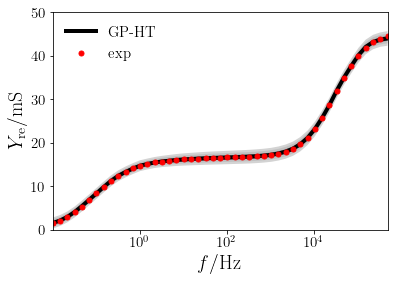

In [13]:
mu_R_inf = np.mean(Y_exp.real-mu_star_vec)
plt.fill_between(freq_star_vec, mu_R_inf+mu_star_vec-3*sigma_star_vec, mu_R_inf+mu_star_vec+3*sigma_star_vec,  facecolor='lightgrey')
plt.fill_between(freq_star_vec, mu_R_inf+mu_star_vec-2*sigma_star_vec, mu_R_inf+mu_star_vec+2*sigma_star_vec,  facecolor='silver')
plt.fill_between(freq_star_vec, mu_R_inf+mu_star_vec-sigma_star_vec, mu_R_inf+mu_star_vec+sigma_star_vec,  facecolor='grey')
plt.semilogx(freq_star_vec, mu_R_inf+mu_star_vec, linewidth=4, color='black', label='GP-HT')
plt.semilogx(freq_vec,  Y_exp.real, 'o', markersize=5, color='red', label='exp')
plt.legend(frameon=False, fontsize = 15)

plt.xlabel(r'$f/{\rm Hz}$', fontsize=20)
plt.ylabel(r'$Y_{\rm re}/{\rm mS}$', fontsize = 20)

plt.xlim(freq_min, freq_max)
plt.ylim(0, 50.)

### 3.3) Plot the residuals

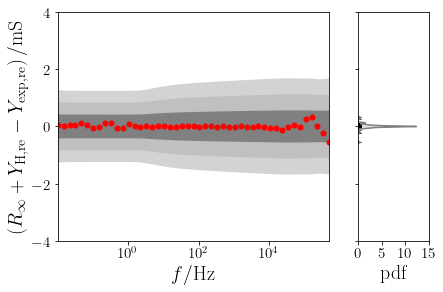

In [17]:
diff_re = mu_R_inf + mu_star_vec - Y_exp.real
#  Combine the scatter plot with the density distribution
fig = plt.figure(figsize=(12,4.2), constrained_layout=False)
gs1 = fig.add_gridspec(nrows=1, ncols=4, left=0.05, right=0.48, wspace=0.4)
ax1 = fig.add_subplot(gs1[0, :-1])
ax2 = fig.add_subplot(gs1[0, -1])
ax1.fill_between(freq_vec, -3*sigma_star_vec, 3*sigma_star_vec,  facecolor='lightgrey')
ax1.fill_between(freq_vec, -2*sigma_star_vec, 2*sigma_star_vec,  facecolor='silver')
ax1.fill_between(freq_vec, -sigma_star_vec, sigma_star_vec,  facecolor='grey')
ax1.plot(freq_vec, diff_re, 'o', markersize=5, color='red')
ax1.set_xlim(freq_min, freq_max)
ax1.set_ylim(-4, 4)
ax1.set_xscale('log')
ax1.set_xlabel(r'$f/{\rm Hz}$', fontsize=20)
ax1.set_ylabel(r'$\left(R_\infty + Y_{\rm H, re} - Y_{\rm exp, re}\right)/{\rm mS}$', fontsize=20)
# density distribution plot
sns.kdeplot(diff_re, ax=ax2, shade=True, color='grey', vertical=True)
sns.rugplot(diff_re, ax=ax2, color='black', vertical=True)
ax2.set_xlim(0, 10)
ax2.set_xticks(np.arange(0., 16, 5))
ax2.set_yticklabels([]) 
ax2.set_ylim(-4., 4.)
ax2.set_xlabel(r'pdf',fontsize=20)

plt.show()